In [31]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [32]:
from dataset import MultiResolutionDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [33]:
dataroot = '../../datasets/ffhq-dataset/images256x256/'
imageSize = 64
batchSize = 1

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
dataset = MultiResolutionDataset(dataroot,
        transforms.Compose([
                transforms.Resize(imageSize),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
            ]),
        256
    )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(2))

In [36]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

In [106]:
from model import Generator

latent = 512
n_mlp = 8
ngf = 64
nc = 3
channel_multiplier = 2
patch_size = 16


generator = Generator(
        patch_size, latent, n_mlp, channel_multiplier=channel_multiplier
    ).to(device)
g_ema = Generator(
        patch_size, latent, n_mlp, channel_multiplier=channel_multiplier
    ).to(device)

accumulate(g_ema, generator, decay=0)

In [107]:
embedding = nn.Embedding(16, 256).to(device)

def get_embedding(i, j):
    assert i < 4 and j < 4, "i and j has to be lower than 4"
    return embedding(torch.tensor(i * 4 + j).long().to(device).repeat(batchSize))

In [108]:
get_embedding(0,0).size()

torch.Size([1, 256])

In [109]:
g_reg_every = 4
g_reg_ratio = g_reg_every / (g_reg_every + 1)

fold = nn.Fold(64,16,stride=16).to(device)

In [110]:
some_noise = torch.randn(1, 3*16*16, 16, device=device)
out = fold(some_noise)
print(out.size())

torch.Size([1, 3, 64, 64])


In [111]:
netG_path = 'experiments/checkpoint/140000.pt'
# netG_path = 'checkpoint/060000.pt'
ckpt = torch.load(netG_path, map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"])

<All keys matched successfully>

In [112]:
fixed_noise = torch.randn(batchSize, latent-256, device=device)
style_vec = [torch.cat([fixed_noise, get_embedding(0,0)], dim=1)]
fake_img,_ = generator(style_vec)
print(fake_img.size())

torch.Size([1, 3, 16, 16])


Text(0.5, 1.0, 'Generated Patch')

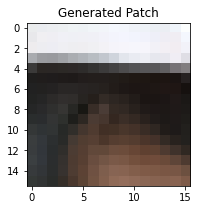

In [113]:
img_show = vutils.make_grid(fake_img, normalize=True, range=(-1, 1))

plt.figure(figsize=(3,3))
img_show_ = img_show.permute(1,2,0).detach().cpu().numpy()
plt.imshow(img_show_)
plt.title('Generated Patch')

In [114]:
sample_img = next(iter(dataloader)).to(device)

Text(0.5, 1.0, 'Sample Image')

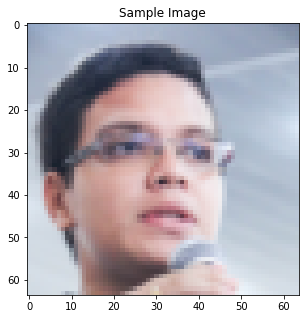

In [115]:
img_show_2 = vutils.make_grid(sample_img, normalize=True, range=(-1, 1))
# vutils.save_image(
#                         sample_img,
#                         f"some_results/real_{str(1).zfill(6)}.png",
#                         nrow=int(1),
#                         normalize=True,
#                         range=(-1, 1),
#                     )
plt.figure(figsize=(5,5))
img_show_2 = img_show_2.permute(1,2,0).detach().cpu().numpy()
plt.imshow(img_show_2)
plt.title('Sample Image')

In [116]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [117]:
pos_labels = []
for j in range(4):
    for i in range(4):
        pos_labels.append(get_embedding(i,j))

pos_labels = torch.cat(pos_labels, dim=0)
print(pos_labels.size())

torch.Size([16, 256])


In [144]:
noise = [torch.randn(16, latent, device=device, requires_grad = True)]
# style_vec = [torch.cat([noise[0], pos_labels.detach()], dim=1)]
fake_img,_ = generator(noise)
print(fake_img.size())

torch.Size([16, 3, 16, 16])


Text(0.5, 1.0, 'Generated Image')

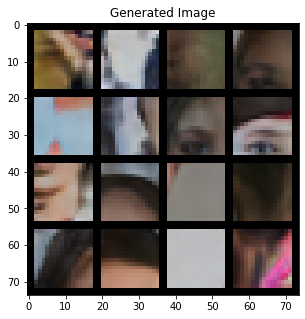

In [145]:
img_show = vutils.make_grid(fake_img, normalize=True, nrow=4)
plt.figure(figsize=(5,5))
img_show_ = img_show.permute(1,2,0).detach().cpu().numpy()
plt.imshow(img_show_)
plt.title('Generated Image')

In [146]:
lr = 1e-1
beta1 = 0.5
parameters_to_optimize = noise + list(generator.parameters())
# optimizer = optim.Adam(noise, lr=lr, betas=(beta1, 0.999))
optimizer = optim.SGD(
                parameters_to_optimize,
                lr=lr * g_reg_ratio,
                momentum = 0.9
#                 betas=(0.9 ** g_reg_ratio, 0.99 ** g_reg_ratio),
            )
criterion = nn.MSELoss().to(device)

In [153]:
niter = 100
losses = []
generator.eval()
requires_grad(generator, False)

for i in tqdm(range(niter)):
    optimizer.zero_grad()
    fake_img,_ = generator(noise)
    fake_img = (fake_img - fake_img.min()) / fake_img.max()
    fake_img = 2 * fake_img - 1.0
    fake_img = fake_img.view(1,16,3*16*16).permute(0,2,1)
    fake_img = fold(fake_img)
    loss = criterion(fake_img, sample_img.detach())
    losses.append(loss.item())
    loss.backward()
    
    optimizer.step()
    
    accumulate(g_ema, generator, 0.999)

  0%|          | 0/100 [00:00<?, ?it/s]

0.11358308047056198


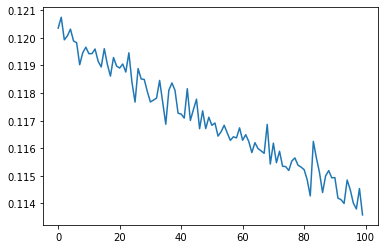

In [154]:
plt.plot(losses)
print(min(losses))

In [62]:
fake_img,_ = generator(noise)
fake_img = fake_img.view(1,16,3*16*16).permute(0,2,1)
fake_img = fold(fake_img)

Text(0.5, 1.0, 'Generated Image')

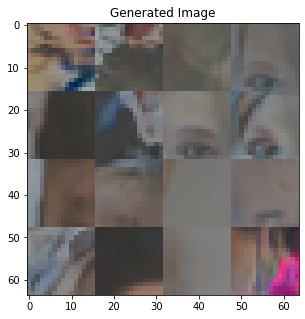

In [155]:
img_show = vutils.make_grid(fake_img, normalize=True, nrow=4)
# vutils.save_image(
#                         fake_img,
#                         f"some_results/fake_normal_style_{str(i).zfill(6)}.png",
#                         nrow=int(1),
#                         normalize=True,
#                         range=(-1, 1),
#                     )
plt.figure(figsize=(5,5))
img_show_ = img_show.permute(1,2,0).detach().cpu().numpy()
plt.imshow(img_show_)
plt.title('Generated Image')

In [186]:
def random_crop_dataset(img):
        _, h, w = img.size()
        th, tw = (16, 16)
        number_patches_sqrt_h = h // th
        number_patches_sqrt_w = w // tw

        if h < th or w < tw:
            raise ValueError(
                "Required crop size {} is larger then input image size {}".format((th, tw), (h, w))
            )

        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, number_patches_sqrt_h, size=(1,)).item()
        j = torch.randint(0, number_patches_sqrt_w, size=(1,)).item()

        position_label = torch.tensor(i * number_patches_sqrt_w + j).long()

        return img[:,i*th:(i+1)*th,j*tw:(j+1)*tw].clone(), position_label

In [187]:
noise_img = torch.randn(3, 64, 64)
out, pos = random_crop_dataset(noise_img)
print(out.size())
print(pos)

torch.Size([3, 16, 16])
tensor(12)


In [5]:
from dataset import MultiResolutionDatasetRandomCrop
transform = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )
dataset = MultiResolutionDatasetRandomCrop(dataroot, transform, 256)

In [9]:
dataset[5][1]

tensor(6)

In [29]:
embedding = nn.Embedding(16, )
for i in range(16):
    print(embedding(torch.tensor(i)))

tensor([0.0752, 0.1200], grad_fn=<EmbeddingBackward>)
tensor([ 1.6994, -2.1308], grad_fn=<EmbeddingBackward>)
tensor([-0.4798, -1.4023], grad_fn=<EmbeddingBackward>)
tensor([1.1683, 1.1872], grad_fn=<EmbeddingBackward>)
tensor([-1.3438,  0.0603], grad_fn=<EmbeddingBackward>)
tensor([0.0631, 0.0668], grad_fn=<EmbeddingBackward>)
tensor([-0.2310, -0.4077], grad_fn=<EmbeddingBackward>)
tensor([-2.6909,  0.2558], grad_fn=<EmbeddingBackward>)
tensor([-1.0492,  0.2012], grad_fn=<EmbeddingBackward>)
tensor([0.2167, 0.6492], grad_fn=<EmbeddingBackward>)
tensor([0.3219, 0.3609], grad_fn=<EmbeddingBackward>)
tensor([-0.5620,  1.3883], grad_fn=<EmbeddingBackward>)
tensor([0.2294, 0.2537], grad_fn=<EmbeddingBackward>)
tensor([1.6832, 1.2689], grad_fn=<EmbeddingBackward>)
tensor([1.7795, 0.9559], grad_fn=<EmbeddingBackward>)
tensor([ 0.1188, -0.9478], grad_fn=<EmbeddingBackward>)
